In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img

In [19]:
import matplotlib.image as img
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans
import pandas as pd

In [52]:
from scipy.spatial import KDTree

In [53]:
import webcolors
import pickle

In [54]:
from webcolors import (
    CSS3_HEX_TO_NAMES,
#     css3_hex_to_names,
    hex_to_rgb,
)

In [55]:
with open('css_color_to_name.p','rb') as F:
    color_to_name = pickle.load(F)

In [56]:
restricted_css3 = {}
for key in CSS3_HEX_TO_NAMES.keys():
    if color_to_name[key] != 'none':
        restricted_css3[key] = CSS3_HEX_TO_NAMES[key]

In [57]:
CSS3_HEX_TO_NAMES = restricted_css3

In [58]:
image_folder = 'static/dataset/coco_val_set/'

In [59]:
image_files = os.listdir(image_folder)
image_paths = [os.path.join(image_folder, i) for i in image_files]

In [60]:
import numpy as np
from math import sqrt

In [61]:
def get_similarity(c1, c2):
    """Computes the pearson correlation coefficient for two colors. The result
    will be between 1.0 (very similar) and -1.0 (no similarity)."""
#     c1 = color_to_rgb(color1)
#     c2 = color_to_rgb(color2)
    s1 = sum(c1)
    s2 = sum(c2)
    sp1 = sum(map(lambda c: pow(c, 2), c1))
    sp2 = sum(map(lambda c: pow(c, 2), c2))
    sp = sum(map(lambda x: x[0] * x[1], zip(c1, c2)))

    return (sp - (s1 * s2 / 3.0)) / sqrt((sp1 - pow(s1, 2) / 3.0) * (sp2 - pow(s2, 2) / 3.0))

In [62]:
from scipy.stats.stats import pearsonr

In [63]:
def convert_using_pearson(rgb_tuple):
    best_similarity = 0
    best_color = 'NA'
    for color in CSS3_HEX_TO_NAMES.keys():
        color_rgb = hex_to_rgb(color)
        similarity_score = pearsonr(color_rgb,rgb_tuple)[0]
        
        if similarity_score > best_similarity:
            best_similarity = similarity_score
            best_color = CSS3_HEX_TO_NAMES[color]
            best_rgb = color_rgb
    return best_color, [best_rgb[0],best_rgb[1],best_rgb[2]]

def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return names[index], [rgb_values[index][0],rgb_values[index][1],rgb_values[index][2]]


def display_matched_colors(original_rgb,matched_rgb):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow([[original_rgb]])
    axarr[1].imshow([[matched_rgb]])
    plt.show()

In [64]:
inverted_css3 = {}
for key,value in CSS3_HEX_TO_NAMES.items():
    inverted_css3[value] = key

In [65]:
histogram_dominant_color = {}

In [66]:
from tqdm import tqdm

In [69]:
def get_dominant_color_clustering(impath):
    batman_image = img.imread(impath)
    r = []
    g = []
    b = []
    for row in batman_image:
        for temp_r, temp_g, temp_b in row:
            r.append(temp_r)
            g.append(temp_g)
            b.append(temp_b)

    batman_df = pd.DataFrame({'red' : r,
                            'green' : g,
                            'blue' : b})

    batman_df['scaled_color_red'] = whiten(batman_df['red'])
    batman_df['scaled_color_blue'] = whiten(batman_df['blue'])
    batman_df['scaled_color_green'] = whiten(batman_df['green'])

    cluster_centers, _ = kmeans(batman_df[['scaled_color_red',
                                        'scaled_color_blue',
                                        'scaled_color_green']], 1)

    dominant_colors = []

    red_std, green_std, blue_std = batman_df[['red',
                                            'green',
                                            'blue']].std()

    for cluster_center in cluster_centers:
        red_scaled, green_scaled, blue_scaled = cluster_center
        dominant_colors.append((
            red_scaled * red_std / 255,
            green_scaled * green_std / 255,
            blue_scaled * blue_std / 255
        ))
    print(red_scaled, green_scaled, blue_scaled)
    return dominant_colors

In [70]:
for impath in tqdm(image_paths):
    dominant_color = get_dominant_color_clustering(impath)
    break
    named_color,_ = convert_rgb_to_names(dominant_color)
    easy_color_name = color_to_name[inverted_css3[named_color]]
    histogram_dominant_color[impath] = easy_color_name

  0%|          | 0/5000 [00:02<?, ?it/s]

-0.5103770327213843 0.8127776336327075 -0.13403981011383298


In [71]:
dominant_color

[(-0.1514891189543041, 0.2730640866830943, -0.02839114544230682)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


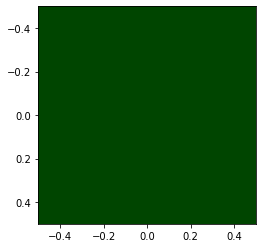

In [73]:
plt.imshow([dominant_color])
plt.show()

In [43]:
# batman_image = img.imread(impath)
# r = []
# g = []
# b = []
# for row in batman_image:
#     for temp_r, temp_g, temp_b in row:
#         r.append(temp_r)
#         g.append(temp_g)
#         b.append(temp_b)

In [ ]:
with open('histogram_dominant_color.p','wb') as F:
    pickle.dump(histogram_dom,F)